# Laboratorio 4 - Práctica 4
### Gonzalo de las Heras de Matías - Jorge de la Fuente Tagarro
## Agrupamiento de jugadores en videojuegos

![title](Images/pubg.png)

### Objetivo 

Bluehole, la empresa encargada del videojuego PlayerUnknown's Battlegrounds quiere introducir nuevos
paquetes dependiendo del tipo de jugador. Para ello dispone de estadísticas de los 200 mejores jugadores.
Aplica un algoritmo de manera que se obtengan dichos grupos.

### Cuestiones 

<ol type="o">
  <li>Utiliza varias configuraciones teniendo en cuenta el número de grupos que se creará y cambiando
cómo se mide la distancia entre individuos. Crea una tabla donde se incluya toda la información y
el número necesario de iteraciones para llegar a dicha solución. Se considera la mejor solución
aquella que necesite menos iteraciones.</li>
  <li>Con la mejor configuración del punto anterior. Utiliza dos criterios para elegir el lugar inicial del
punto central de los grupos. Dibuja cómo se van modificando los grupos y cómo van cambiando
sus centroides en cada iteración. Obten una conclusión acerca de donde deberían situarse los
centroides.</li>
  <li>Estudia que técnicas de preprocesamiento se podrían incluir en base al error cometido en cada
clúster.</li>
</ol>

#### Librerias

In [49]:
import pandas as pd
import matplotlib.pyplot as plt  
import numpy as np  
from pylab import *
from sklearn.cluster import KMeans  
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#### Dirección del dataset

In [50]:
DIR_DATASET = "Datos/PUBG.csv"

## 1. Preparación del dataset

### 1.1 Carga y limpieza de campos nulos

In [51]:
Datos = pd.read_csv(DIR_DATASET)
print("Hay", len(Datos), "registros.")
nulos = pd.DataFrame(Datos.isnull().sum(), columns=["Número de nulos"])
nulos[nulos["Número de nulos"] != 0]

Hay 99 registros.


,Número de nulos


In [52]:
Datos_Solo = Datos.loc[:, "solo_KillDeathRatio":"solo_DBNOs"]
Datos_Duo = Datos.loc[:, "duo_KillDeathRatio":"duo_DBNOs"]
Datos_Squad = Datos.loc[:, "squad_KillDeathRatio":"squad_DBNOs"]

<font color="blue">Nos centraremos en crear un modelo para el modo en solitario pues el estilo de juego de un mismo jugador cambia si juega en pareja o en grupos de 4.</font>

In [53]:
Datos_Solo.head()

,solo_KillDeathRatio,solo_WinRatio,solo_TimeSurvived,solo_RoundsPlayed,solo_Wins,solo_WinTop10Ratio,solo_Top10s,solo_Top10Ratio,solo_Losses,solo_Rating,...,solo_RideDistance,solo_MoveDistance,solo_AvgWalkDistance,solo_AvgRideDistance,solo_LongestKill,solo_Heals,solo_Revives,solo_Boosts,solo_DamageDealt,solo_DBNOs
0,3.14,17.65,18469.14,17,3,0.83,4,23.5,14,1559.78,...,27537.53,56461.84,2202.40,2764.50,304.87,33,0,29,4341.06,0
1,4.41,18.18,33014.86,33,6,0.36,11,33.3,27,1884.53,...,117837.74,165706.51,2017.38,5188.69,351.95,60,0,88,12970.39,0
2,3.60,0.00,4330.44,5,0,0.00,1,20.0,5,1255.92,...,7683.20,14023.99,1375.70,3052.50,125.76,5,0,3,1648.82,0
3,14.00,50.00,13421.82,8,4,0.67,6,75.0,4,1798.70,...,30314.83,47894.53,2197.46,3789.35,412.25,8,0,24,6015.57,0
4,10.50,33.33,9841.04,6,2,0.40,5,83.3,4,1668.67,...,22425.36,39161.77,2789.40,3737.56,307.97,12,0,21,3824.89,0


### 1.2 Preparación de los datos
<br>
<font color="blue">Centramos los datos y reducimos la dimensionalidad para poder pintar un mapa en 2 dimensiones.</font>

In [54]:
# Centramos los datos.
datos_centrados = StandardScaler().fit_transform(Datos_Solo.values)

# Usamos la libreria de sklearn par proyectar los datos.
modelo_PCA = PCA(n_components=2)

# Capturamos las componentes principales.
componentes_principales = modelo_PCA.fit_transform(datos_centrados)

# Creamos el dataframe.
AutoValores = pd.DataFrame()

# Confeccionamos el dataframe con las columnas deseadas.
AutoValores["autovalor"] = modelo_PCA.explained_variance_
AutoValores["% varianza"] = modelo_PCA.explained_variance_ratio_ * 100
AutoValores["% acum"] = modelo_PCA.explained_variance_ratio_.cumsum() * 100

# Mostramos el dataframe.
AutoValores

,autovalor,% varianza,% acum
0,18.902834,40.678036,40.678036
1,8.265763,17.787544,58.465580


<font color="blue">Con 2 componentes podemos representar el conjunto de datos con un 58% de representatividad.</font>

In [55]:
# Creamos el dataframe con las componentes principales calculadas para cada registro.
Df_Componentes_Principales = pd.DataFrame(data=componentes_principales, columns=["comp_1", "comp_2"])

# Añadimos la columna con el nombre del estado.
Df_Componentes_Principales["jugador"] = Datos["player_name"]

# Mostramos el dataframe.
Df_Componentes_Principales.head(10)

,comp_1,comp_2,jugador
0,-3.033412,0.125895,BreakNeck
1,-1.565505,-1.427187,Blackwalk
2,-4.253197,2.318503,mercedes_benz
3,-2.960077,-7.016332,DORA
4,-3.084368,-7.073508,n2tstar
5,-2.275974,-2.795215,coldoxygen
6,4.421299,0.499020,Giken
7,-2.142978,-1.224582,KoreaNo1
8,-1.013052,1.033492,undor
9,-3.413834,-1.031107,Fordune


## 2. Construcción del modelo

<font color="blue">Creamos varios modelos con distinto valor K para hallar el mejor valor para ella.</font>

Probando modelo con K= 1
--------------------------


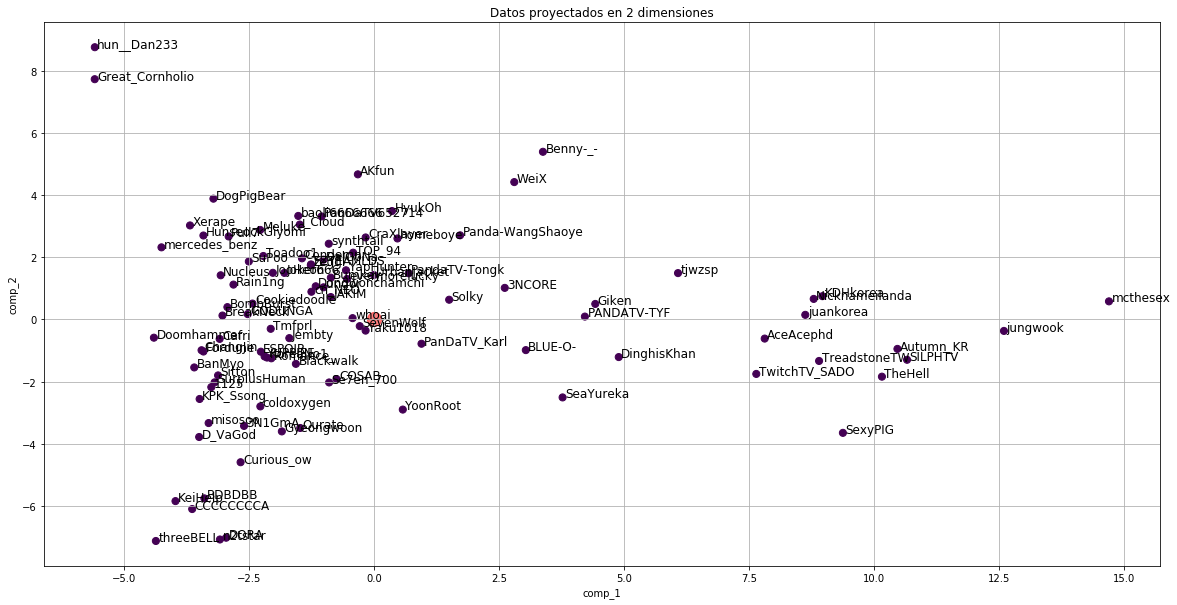

Probando modelo con K= 2
--------------------------


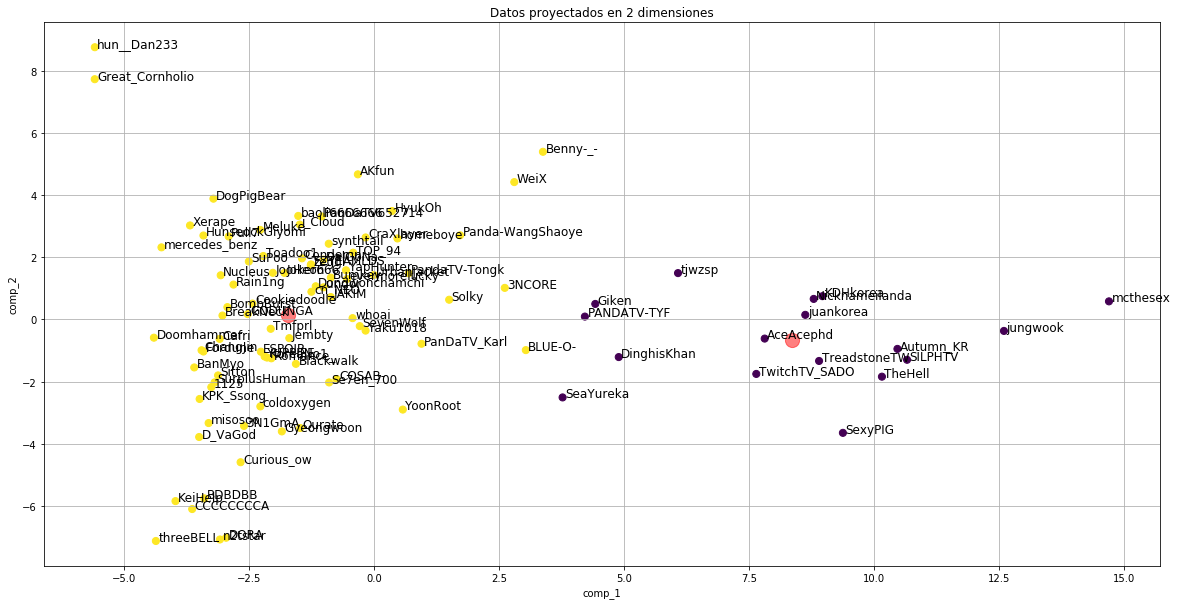

Probando modelo con K= 3
--------------------------


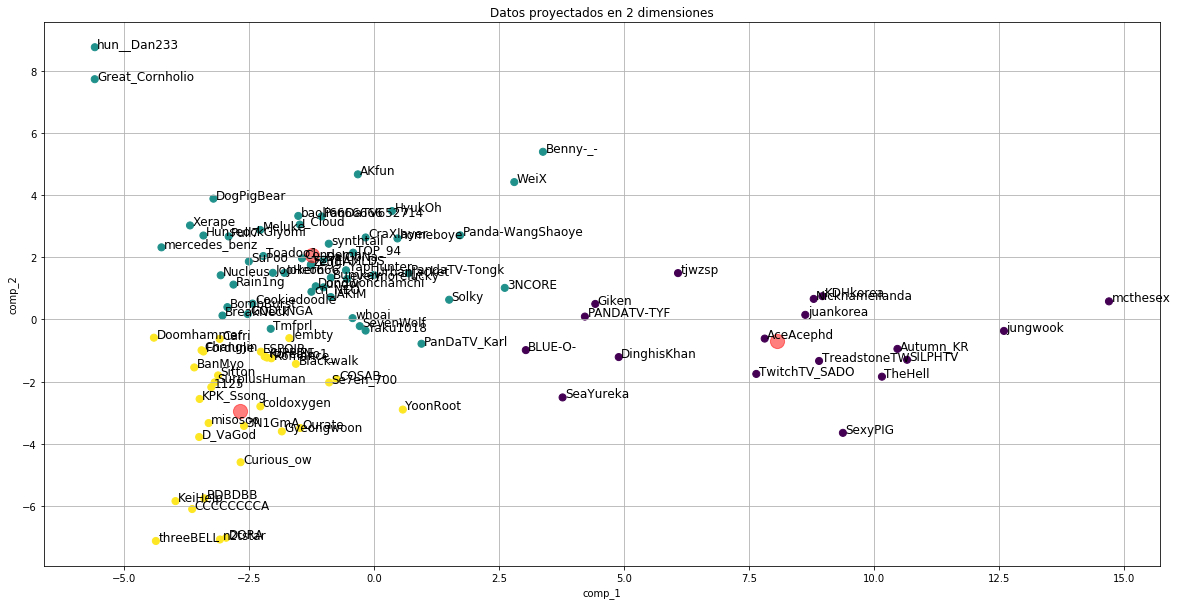

Probando modelo con K= 4
--------------------------


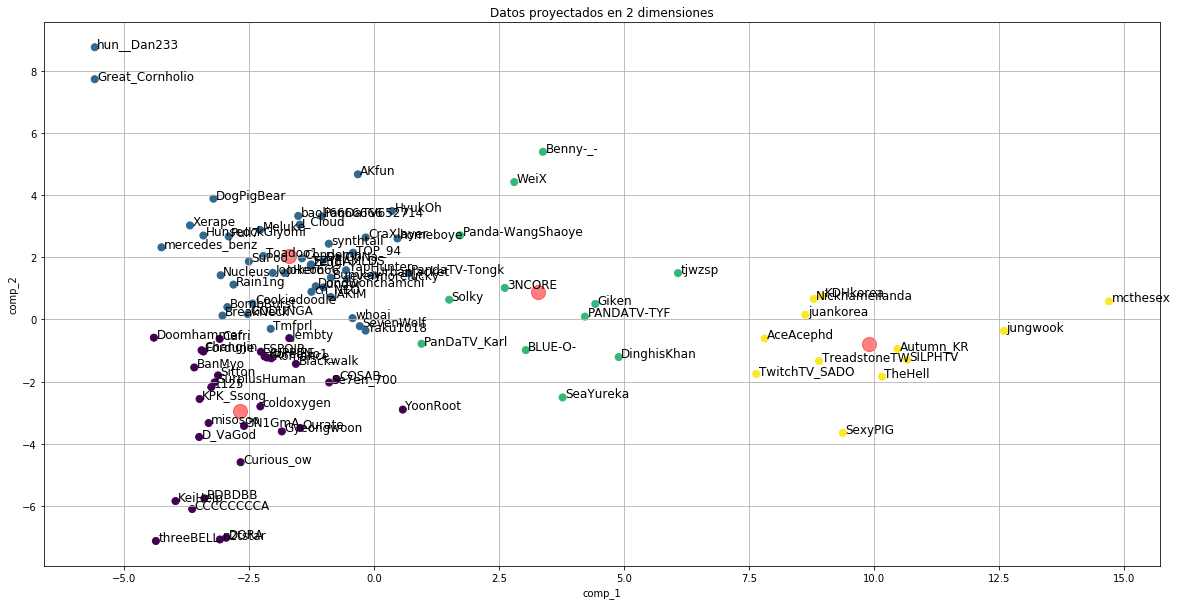

Probando modelo con K= 5
--------------------------


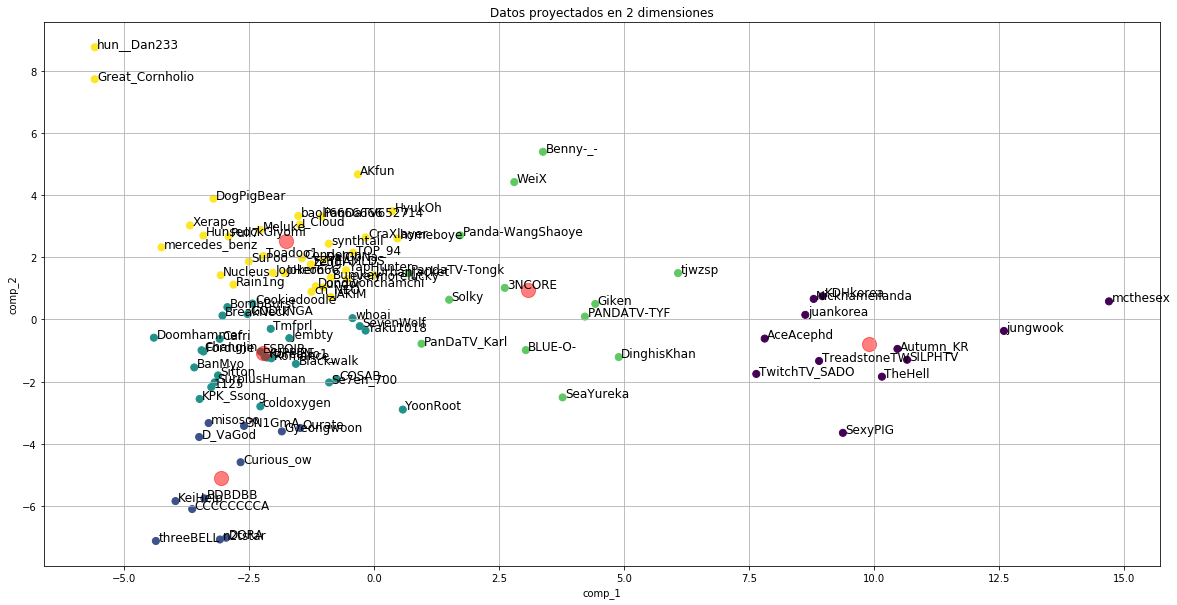

Probando modelo con K= 6
--------------------------


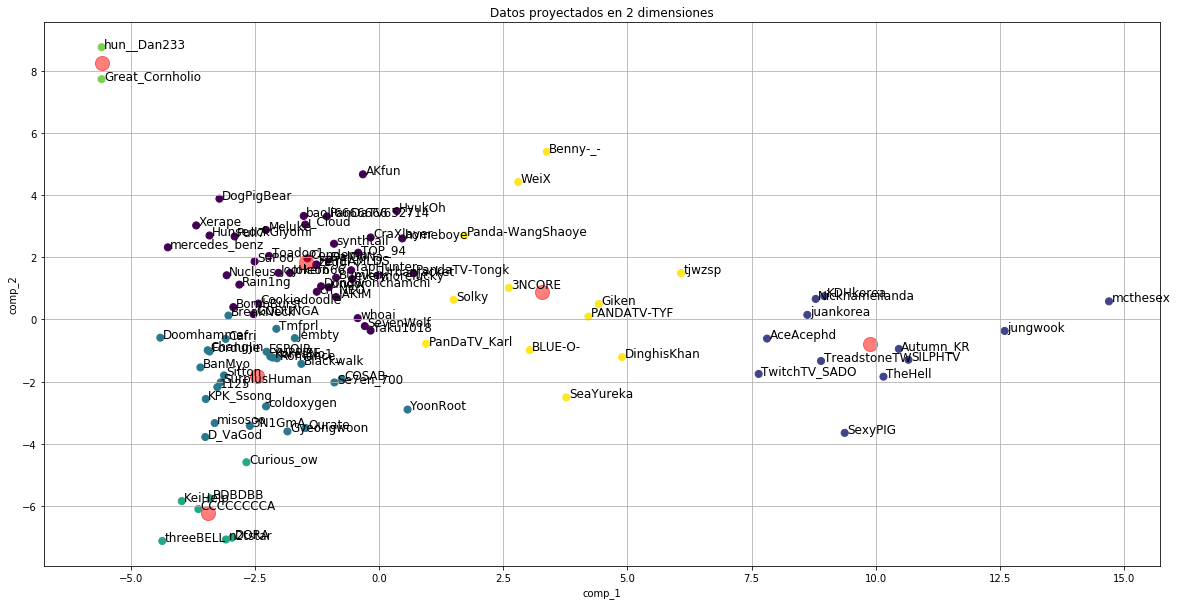

Probando modelo con K= 7
--------------------------


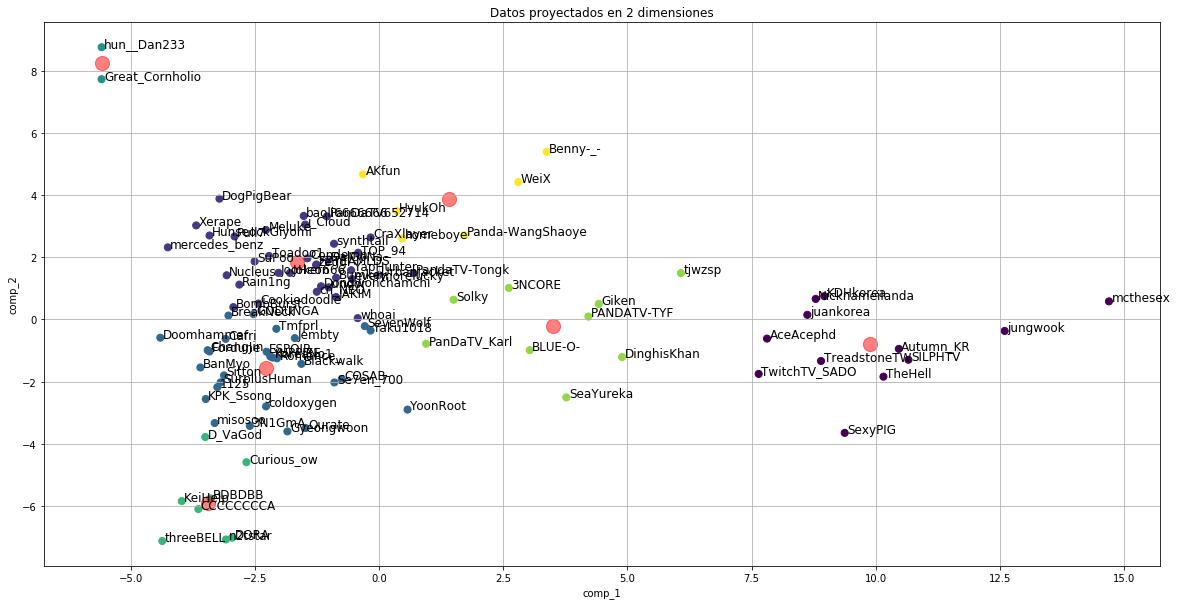

Probando modelo con K= 8
--------------------------


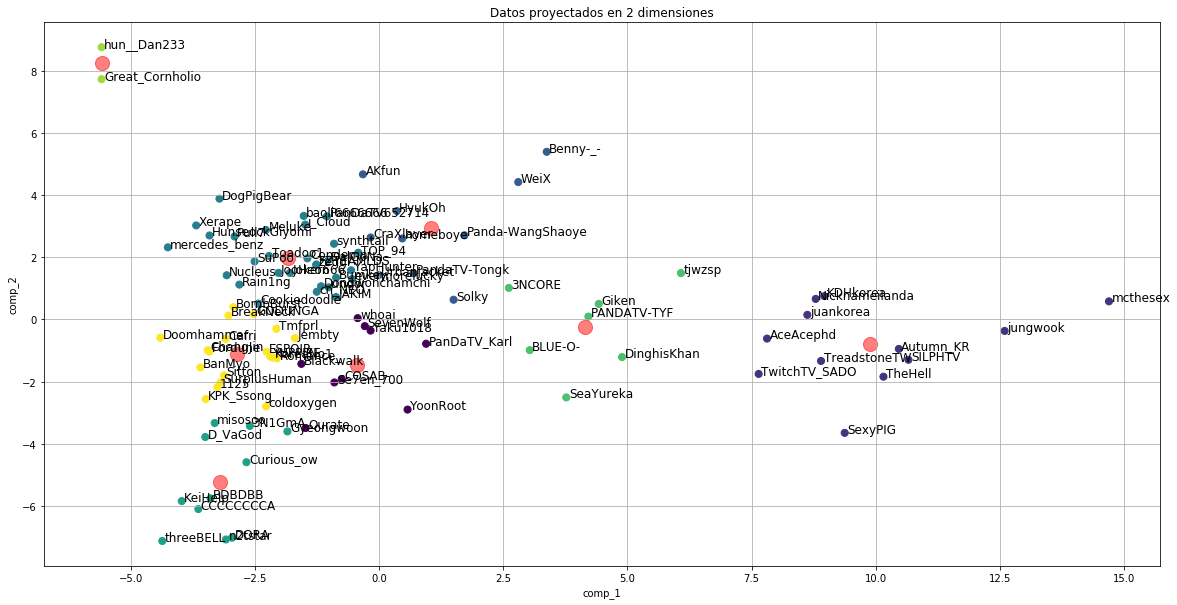

Probando modelo con K= 9
--------------------------


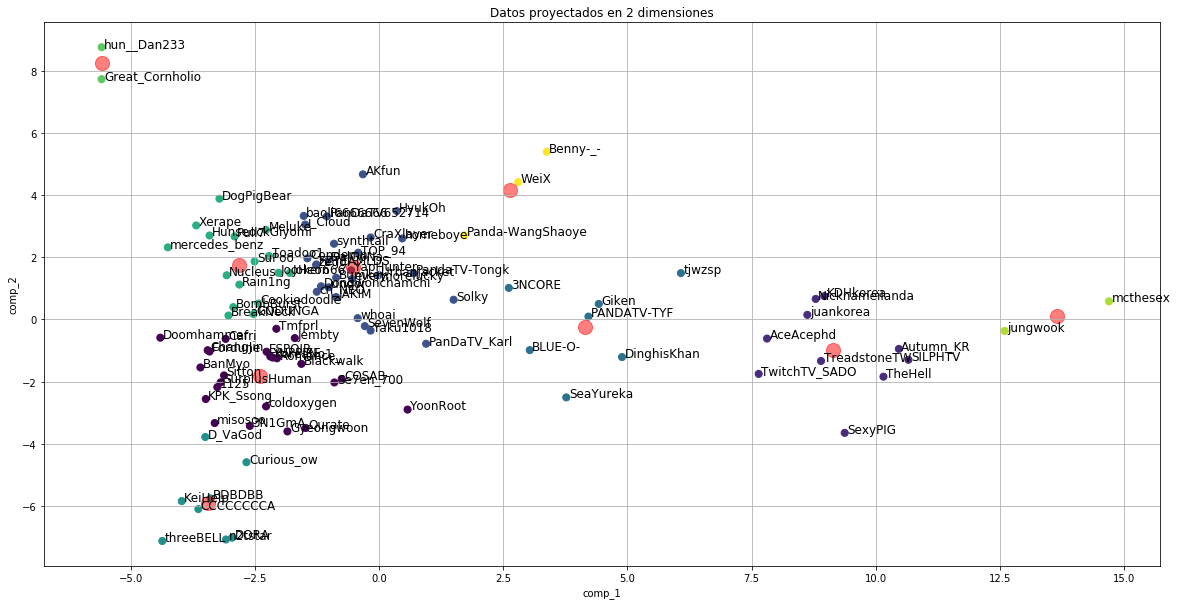

In [56]:
# Distancias de cada modelo.
distancias = {}

# Bucle de creación de modelos con K distintos.
for K in range(1, 10):
    
    print("Probando modelo con K=", K)
    print("--------------------------")
    
    # Creación del modelo.
    modelo = KMeans(n_clusters=K, max_iter=50)
    
    # Entrenamiento del modelo.
    modelo.fit(componentes_principales)
    
    # Predicción de los grupos del dataset.
    prediccion = modelo.predict(componentes_principales)
    
    # Dibujamos el mapa de agrupaciones.
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.scatter(Df_Componentes_Principales["comp_1"], Df_Componentes_Principales["comp_2"], \
                c=prediccion, s=50, cmap='viridis')
    for i, txt in enumerate(Df_Componentes_Principales["jugador"]):
        pos = (Df_Componentes_Principales["comp_1"][i] + 0.05, Df_Componentes_Principales["comp_2"][i])
        ax.annotate(txt, (Df_Componentes_Principales["comp_1"][i], Df_Componentes_Principales["comp_2"][i]), \
                    pos, 'data', size=12)

    # Calculamos los centroides y los añadimos al mapa.
    centroides = modelo.cluster_centers_
    plt.scatter(centroides[:, 0], centroides[:, 1], c='red', s=200, alpha=0.5)
    plt.grid(True)
    plt.xlabel('comp_1')
    plt.ylabel('comp_2')
    plt.title('Datos proyectados en 2 dimensiones')
    plt.show()
    
    # Guardamos la suma del cuadrado de las distancias de las muestras al centroide más cercano.
    distancias[K] = modelo.inertia_

<font color="blue">Estudiamos la evolución de la suma del cuadrado de las distancias de las muestras al centroide más cercano. Nos fijaremos cuando el decaimiento del valor se reduzca significativamente.</font>

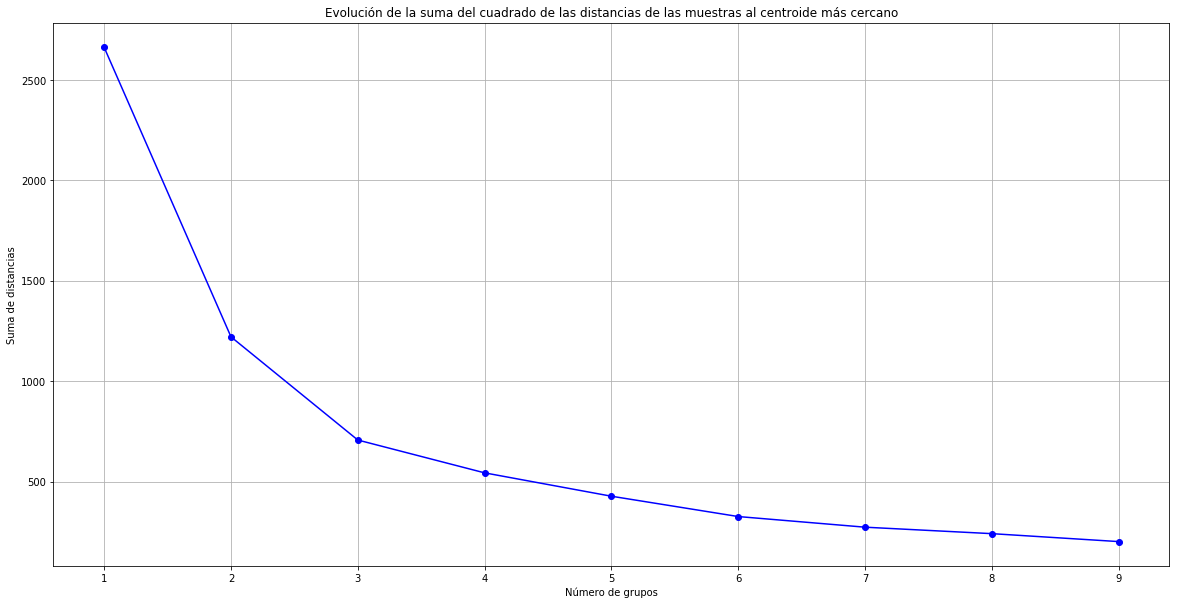

In [57]:
sfig, ax = plt.subplots(figsize=(20, 10))
plt.plot(list(distancias.keys()), list(distancias.values()), 'bo-')
plt.grid(True)
plt.title("Evolución de la suma del cuadrado de las distancias de las muestras al centroide más cercano")
plt.xlabel("Número de grupos")
plt.ylabel("Suma de distancias")
plt.show()

<font color="blue">Tomamos con valor K, 4. Es el momento donde el decaimiento se reduce significativamente.</font>

## 3. Modelo final

<font color="blue">Estudiamos el modelo final con K=4.</font>

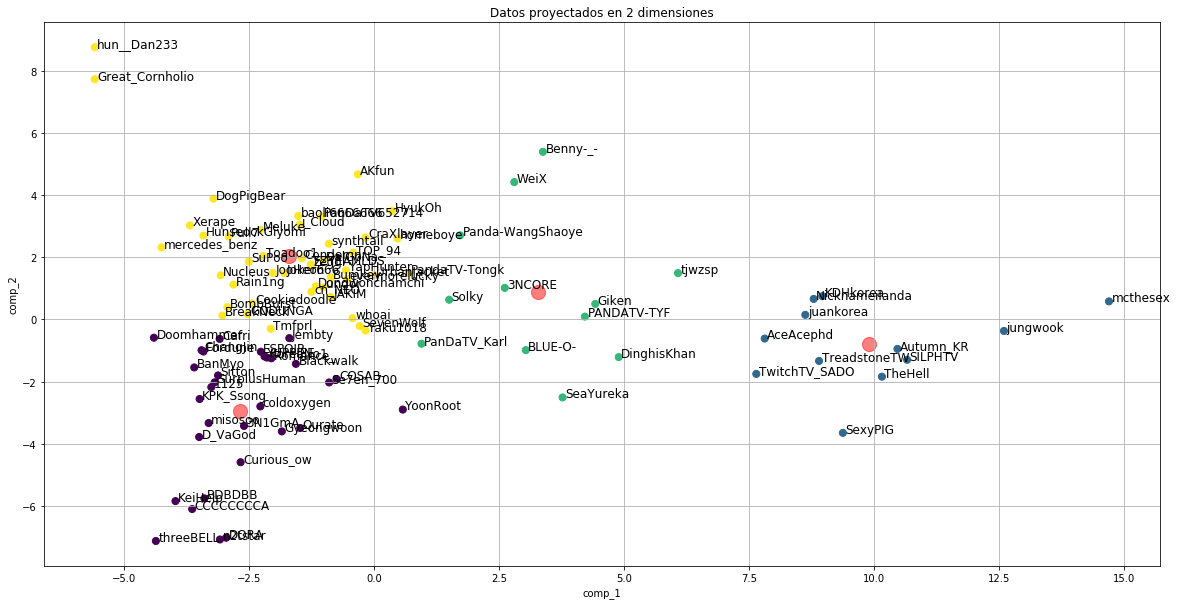

In [58]:
# Creación del modelo.
modelo = KMeans(n_clusters=4, max_iter=50)

# Entrenamiento del modelo.
modelo.fit(componentes_principales)

# Predicción de los grupos del dataset.
prediccion = modelo.predict(componentes_principales)

# Dibujamos el mapa de agrupaciones.
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(Df_Componentes_Principales["comp_1"], Df_Componentes_Principales["comp_2"],  \
            c=prediccion, s=50, cmap='viridis')
for i, txt in enumerate(Df_Componentes_Principales["jugador"]):
    pos = (Df_Componentes_Principales["comp_1"][i] + 0.05, Df_Componentes_Principales["comp_2"][i])
    ax.annotate(txt, (Df_Componentes_Principales["comp_1"][i], Df_Componentes_Principales["comp_2"][i]), \
                pos, 'data', size=12)

# Calculamos los centroides y los añadimos al mapa.
centroides = modelo.cluster_centers_
plt.scatter(centroides[:, 0], centroides[:, 1], c='red', s=200, alpha=0.5)
plt.grid(True)
plt.xlabel('comp_1')
plt.ylabel('comp_2')
plt.title('Datos proyectados en 2 dimensiones')
plt.show()

<font color="blue">Observamos:
<ul>
    <li>Amarillo: Tiene un grupo muy compacto salvo por lo dos valores atípicos hun_Dan233, Great_Cornholio. Podríamos borrarlos del dataset y aumentariamos la calidad del centroide. Actualmente, su posición se ve muy afectada por estos 2 jugadores que están muy alejados.</li>
    <li>Verde: Tiene un grupo muy disperso, el error es alto.</li>
    <li>Azul: Tiene un grupo más o menos compacto salvo por mcthesex y jungwook.</li>
    <li>Morado: Tiene un grupo compacto pero un un subgrupo en la parte inferior separada el subgrupo principal. El centroide se ve desplazado debido a la existencia de este subgrupo separado.</li>
</ul>
</font>

<font color="blue">Como preprocesamiento podemos analizar las componentes principales para reducir la dimensión, facilitando cálculo, pudiendo dibujar un mapa en 2D, si usamos 2 componentes. También podemos eliminar valores atípicos o agrupar información que haga referencia a características similares</font>

## Referencias

<ul>
    <li>https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html</li>
    <li>Apuntes de la asignatura</li>
</ul>